In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import seaborn as sb
import flask
import time
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

In [2]:
%matplotlib inline
plt.style.use('ggplot')
# full_df = pd.read_csv(r"C:\Users\Nicz\Documents\GitHub\3204-CourseWork2\shuffled-noIPV6.csv")
full_df = pd.read_csv(r"shuffled-noIPV6.csv")

print(f"[*] Shape of dataset: {full_df.shape}")
from sklearn.utils import shuffle
full_df.drop(full_df.columns[0], axis=1, inplace=True)
full_df = shuffle(full_df)

print(full_df.tail())
print("\n")

[*] Shape of dataset: (92704, 15)
       @timestamp           src_ip src_port           dst_ip dst_port  \
5995   1666591877        10.0.0.20    34298        10.0.0.21     3306   
29535  1666542079    192.168.106.1    61401  192.168.106.130       53   
3730   1666630741  192.168.106.130        0    192.168.236.1        0   
60885  1666692055    100.64.19.103    44618     100.64.19.22     8443   
84922  1666542072                0    53627  192.168.106.130       53   

                                                Protocol http_request_method  \
5995                                               mysql                   0   
29535  2022-10-24 00:21:03 ALLOW UDP 192.168.106.1 19...                 UDP   
3730                                                ICMP                   0   
60885                                                TCP                   0   
84922                                                  0                   0   

      http_request_referrer http_response_code

In [3]:
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=" ", value= "")
full_df["src_port"] = full_df["src_port"].replace(regex=" ", value="")
full_df["src_port"] = full_df["src_port"].replace(regex="dns", value="53")
full_df["src_port"] = full_df["src_port"].replace(regex="tls", value="0")
full_df["dst_port"] = full_df["dst_port"].replace(regex="dns", value="53")
full_df["dst_ip"] = full_df["dst_ip"].replace(regex="\S*:+\S+", value="0")

In [4]:
scores = {}
scores_list= []

k_value=[]
model_scores={}
accuracy_dict={}
precision_dict={}
cm_dict={}
recall_dict={}
f1_dict={}

algo_accuracy={}
algo_precision={}
algo_recall={}
algo_f1={}

def scoring_metrics(y_test, y_pred, model):
    print(f"y_test size:{y_test.size} y_pred size:{y_pred.size}")
    KNN_accuracy = metrics.accuracy_score(y_test, y_pred)
    KNN_precision = metrics.precision_score(y_test, y_pred, average="weighted")
    KNN_recall = metrics.recall_score(y_test, y_pred, average="weighted")
    KNN_f1_score = metrics.f1_score(y_test, y_pred, average="weighted")
    
    scores[model] = KNN_accuracy
    scores_list.append(KNN_accuracy)
    cm = metrics.confusion_matrix(y_test, y_pred, labels=['-','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'])
    
    k_value.append(model)
    accuracy_dict[model]= KNN_accuracy
    precision_dict[model]= KNN_precision
    recall_dict[model]= KNN_recall
    f1_dict[model]= KNN_f1_score
        
    print(f"Confusion Matrix: {cm}")
    
    print(f"\n[*] Model: {model}")
    print("[*]Precision: {:.3f}%".format(KNN_precision))
    print("[*] Recall: {:.3f}%".format(KNN_recall))

    print("[*] Accuracy: {:.3f}%".format(KNN_accuracy))
    print("[*] F1_score: {:.3f}%".format(KNN_f1_score))


In [5]:
# df = full_df.head(25000)
df = full_df.head(1000)
data_orig = df.copy()

In [6]:
print("Doing")
from sklearn.preprocessing import OneHotEncoder
df.replace(to_replace=["None"], value=np.nan, inplace=True)
clean_df = df.fillna(str(0))
clean_x = clean_df.iloc[:, :13].values
clean_y = clean_df["category"].values
features = df.columns.values[:-1]

for label in clean_df.columns:
    for index, rows in clean_df.iterrows():
        new_ip = ""
        ip = str(rows[label])
        if re.search("\d+\.\d+\.\d+\.\d+", ip):
            octets = ip.split(".")
            for octet in octets:
                octet = octet.rjust(3,"0")
                new_ip += octet
            clean_df[label][index] = new_ip

clean_df["http_response_code"] = clean_df["http_response_code"].replace('HTTP/1.1"', value="0")
clean_df["src_ip"] = clean_df["src_ip"].replace('::1', value="0")
clean_df["dst_ip"] = clean_df["dst_ip"].replace('::1', value="0")
print("Done")

Doing


C:\Users\kahow\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-6-be49f98fa88c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[label][index] = new_ip


Done


In [7]:
clean_x = clean_df.iloc[:, :13]
column_trans = make_column_transformer((OneHotEncoder(sparse=False), ['Protocol', 'http_request_method', 'http_request_referrer', 'url_path', 'user_agent_original', 'sql_method', 'sql_query']),remainder='passthrough')
test = column_trans.fit_transform(clean_x)

# K-Means

In [8]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Normalisation using MinMaxScaler
mms = MinMaxScaler()
mms.fit(test)
data_transformed = mms.transform(test)

In [10]:
kmeans = KMeans(n_clusters=5)

In [11]:
#apply PCA to our dataset with n_components=0.95. 
#This will select the number of components while preserving 95% of the variability in the data
pca = PCA(n_components = 0.95)
reduced = pca.fit_transform(data_transformed)
label = kmeans.fit_predict(reduced)
center = np.array(kmeans.cluster_centers_)

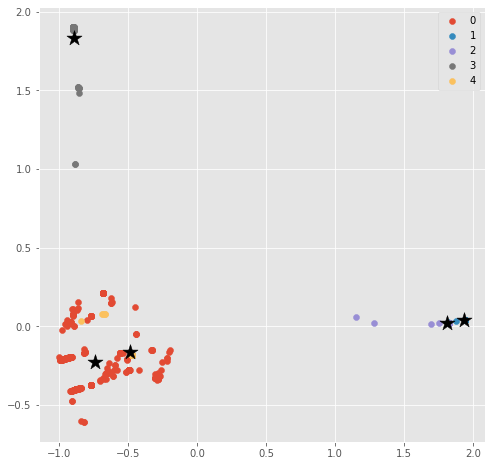

In [12]:
#plot clustering graph with PCA
plt.figure(figsize=(8,8))
uniq = np.unique(label)
for i in uniq:
  plt.scatter(reduced[label == i , 0] , reduced[label == i , 1] , label = i)
plt.scatter(center[:,0], center[:,1], marker="*", c='black', s=250)
plt.legend()
plt.savefig('static/kmeans_scatterplot.png')
plt.show()

# Table

In [13]:
#Table of Relationship between cluster and category
data_orig['label_'] = kmeans.labels_
ct = pd.crosstab(data_orig['category'], data_orig['label_'])
print(ct)

label_              0    1    2   3   4
category                               
ldap_enumeration    1    0    0   0   0
nmap_scan           0    0    0   0  80
port_scan         468    0    0   0   0
smtp_enumeration    4    0    0   0   0
sql_enumeration    53    0    0  73   0
web_enumeration    43  175  103   0   0


# Elbow

In [14]:
#the sum of squared distance between each point and the centroid in a cluster
wcss = []
for i in range(1,15):
   model = KMeans(n_clusters = i)
   model.fit(data_transformed)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,15), wcss)
kn = KneeLocator(range(1,15), wcss, curve='convex', direction='decreasing')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# KNN

In [15]:
x_train, x_test, y_train, y_test = train_test_split(test, clean_y, test_size=0.3)

In [16]:
scores = {}
scores_list= []
ktrainingtime={}
kpredictiontime={}

range_k = range(100, 160, 11)
knn = ""
skip = False

for k in range_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(x_train, y_train)
    timetaken = time.time() - start_time
    ktrainingtime[k] = timetaken
    
    timetaken = 0 
    
    start_time = time.time()
    y_pred = knn.predict(x_test)
    timetaken = time.time() - start_time
    kpredictiontime[k] = timetaken
    
    scoring_metrics(y_test, y_pred, f"{k}")
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    
print(ktrainingtime)
print(kpredictiontime)

y_test size:300 y_pred size:300
Confusion Matrix: [[  0   0   0   0   0   0]
 [  0  22   0   0   0   0]
 [  0   0 146   0   1   0]
 [  0   0   1   0   0   1]
 [  0   0  27   0  11   0]
 [  0   0  11   0   0  80]]

[*] Model: 100
[*]Precision: 0.876%
[*] Recall: 0.863%
[*] Accuracy: 0.863%
[*] F1_score: 0.842%
y_test size:300 y_pred size:300
Confusion Matrix: [[  0   0   0   0   0   0]
 [  0  22   0   0   0   0]
 [  0   0 146   0   1   0]
 [  0   0   1   0   0   1]
 [  0   0  27   0  11   0]
 [  0   0  11   0   0  80]]

[*] Model: 111
[*]Precision: 0.876%
[*] Recall: 0.863%
[*] Accuracy: 0.863%
[*] F1_score: 0.842%
y_test size:300 y_pred size:300


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: [[  0   0   0   0   0   0]
 [  0   3   0   0   0  19]
 [  0   0 146   0   1   0]
 [  0   0   1   0   0   1]
 [  0   0  27   0  11   0]
 [  0   0  11   0   0  80]]

[*] Model: 122
[*]Precision: 0.819%
[*] Recall: 0.800%
[*] Accuracy: 0.800%
[*] F1_score: 0.758%
y_test size:300 y_pred size:300


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix: [[  0   0   0   0   0   0]
 [  0   3   0   0   0  19]
 [  0   0 146   0   1   0]
 [  0   0   1   0   0   1]
 [  0   0  27   0  11   0]
 [  0   0  11   0   0  80]]

[*] Model: 133
[*]Precision: 0.819%
[*] Recall: 0.800%
[*] Accuracy: 0.800%
[*] F1_score: 0.758%
y_test size:300 y_pred size:300
Confusion Matrix: [[  0   0   0   0   0   0]
 [  0   3   0   0   0  19]
 [  0   0 146   0   1   0]
 [  0   0   1   0   0   1]
 [  0   0  27   0  11   0]
 [  0   0  11   0   0  80]]

[*] Model: 144
[*]Precision: 0.819%
[*] Recall: 0.800%
[*] Accuracy: 0.800%
[*] F1_score: 0.758%
y_test size:300 y_pred size:300
Confusion Matrix: [[  0   0   0   0   0   0]
 [  0   3   0   0   0  19]
 [  0   0 147   0   0   0]
 [  0   0   1   0   0   1]
 [  0   0  38   0   0   0]
 [  0   0  11   0   0  80]]

[*] Model: 155
[*]Precision: 0.682%
[*] Recall: 0.767%
[*] Accuracy: 0.767%
[*] F1_score: 0.690%
{100: 0.022310256958007812, 111: 0.019216537475585938, 122: 0.019055604934692383, 133: 0.0221660137

C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
#dictionary to store processing times
algotrainingtime = {}
algopredictiontime = {}

clf = RandomForestClassifier(criterion="gini",
                             min_samples_split = 20,
                             min_samples_leaf = 6,
                             max_depth = 100,
                             n_estimators=500,
                             random_state=5) #can put any number here
start_time =time.time()
clf.fit(x_train, y_train)
rftrainingtimetaken = time.time() - start_time
algotrainingtime["Random Forest"] = rftrainingtimetaken

start_time =time.time()
y_pred = clf.predict(x_test)
rfpredictiontimetaken = time.time() - start_time
algopredictiontime["Random Forest"] = rfpredictiontimetaken

# Processing Time Comparision [RF & KNN]

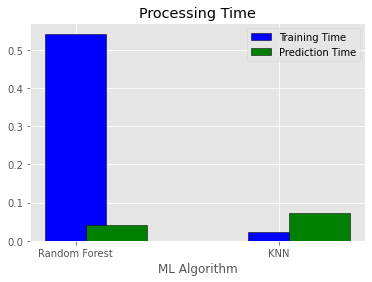

In [18]:
#Update the algotime dictionaries with KNN's results
algotrainingtime["KNN"] = ktrainingtime[133]
algopredictiontime["KNN"] = kpredictiontime[133]

#Plot the processing time graphs
plt.title('Processing Time')
plt.xlabel('ML Algorithm')

trainingtime = algotrainingtime.values()
predictiontime = algopredictiontime.values()

x_axis = np.arange(len(algotrainingtime))
width = 0.2
#multi bar charts
plt.bar(x_axis, trainingtime, color = 'b', width = 0.3, edgecolor = 'black',label='Training Time')
plt.bar(x_axis + width, predictiontime, color = 'g',width = 0.3, edgecolor ='black',label='Prediction Time')

plt.xticks(x_axis,algotrainingtime.keys())
plt.legend(loc="upper right")
plt.savefig('static/ProcessingTime_Comparison.png')
plt.show()

# Random Forest's Confusion Matrix

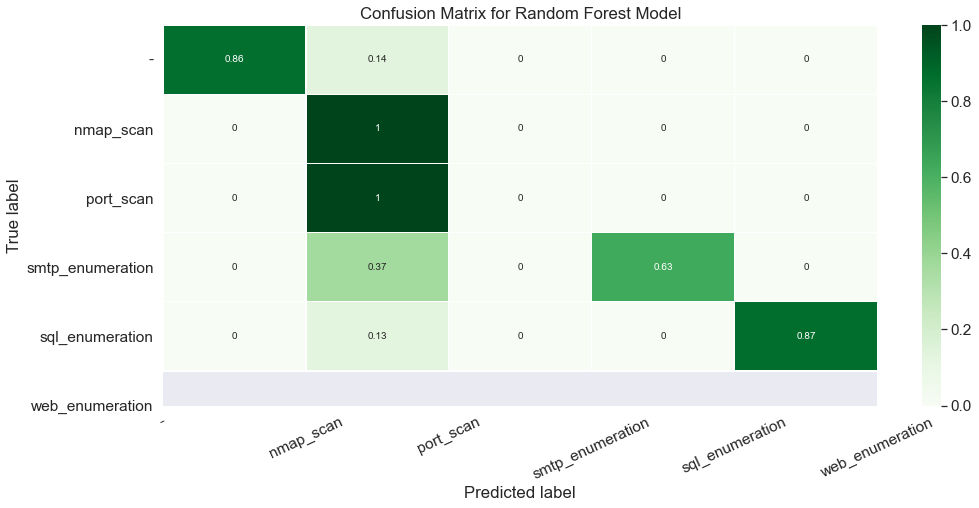

Classification Report 
 {'-': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'nmap_scan': {'precision': 0.8636363636363636, 'recall': 1.0, 'f1-score': 0.9268292682926829, 'support': 19}, 'port_scan': {'precision': 1.0, 'recall': 0.8258426966292135, 'f1-score': 0.9046153846153846, 'support': 178}, 'smtp_enumeration': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, 'sql_enumeration': {'precision': 0.631578947368421, 'recall': 1.0, 'f1-score': 0.7741935483870968, 'support': 24}, 'web_enumeration': {'precision': 0.8681318681318682, 'recall': 1.0, 'f1-score': 0.9294117647058824, 'support': 79}, 'micro avg': {'precision': 0.8966666666666666, 'recall': 0.8966666666666666, 'f1-score': 0.8966666666666666, 'support': 300}, 'macro avg': {'precision': 0.5605578631894421, 'recall': 0.6376404494382023, 'f1-score': 0.5891749943335078, 'support': 300}, 'weighted avg': {'precision': 0.9271646774278353, 'recall': 0.8966666666666666, 'f1-score': 0.9021182304405149, 's

C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score,recall_score
from sklearn.metrics import confusion_matrix

## ==== CONFUSION MATRIX ====
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['-','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

RF_accuracy= accuracy_score(y_test, y_pred)
algo_accuracy["Random Forest"]= RF_accuracy

RF_precision = precision_score(y_test, y_pred,average="weighted")
algo_precision["Random Forest"] = RF_precision

R1_f1_score = f1_score(y_test, y_pred,average="weighted")
algo_f1["Random Forest"]=R1_f1_score

R1_recall = recall_score(y_test, y_pred,average="weighted")
algo_recall["Random Forest"]=R1_recall

print("Classification Report \n" , classification_report(y_pred, y_test, labels=['-','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'], output_dict=True))

# KNN's Confusion Matrix

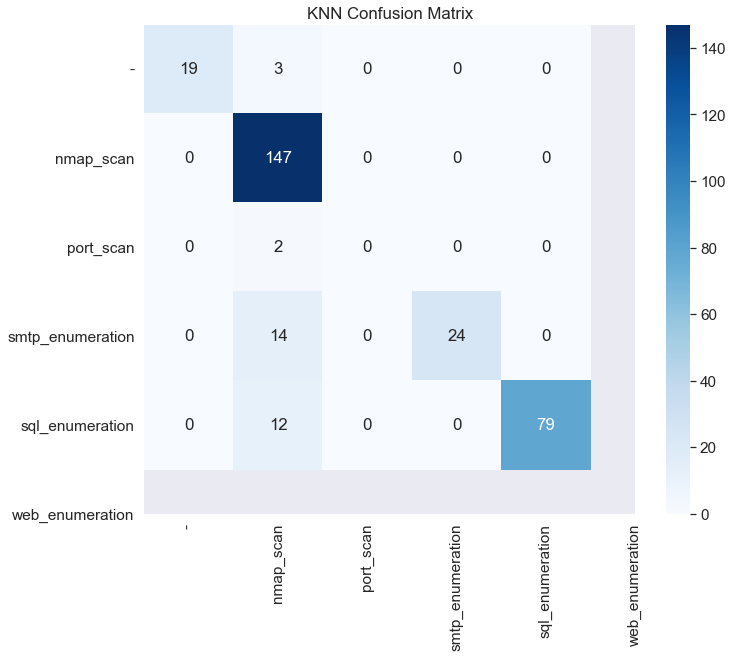

In [20]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(11, 9))

categories = ['-','nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration']
ax.set_xticklabels(categories, rotation=45)
                   
sb.heatmap(confusion_matrix, annot=True, fmt='0', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('KNN Confusion Matrix')
plt.savefig('static/KNN_ConfusionMatrix.png')

# KNN's optimal value

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

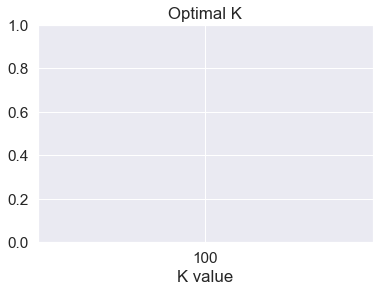

In [21]:
plt.title('Optimal K')
plt.xlabel('K value')

k_value = list(accuracy_dict.keys())

algo_accuracy["KNN"]= accuracy_dict['133']
plt.plot(k_value, accuracy_dict.values(), label = "Accuracy", linestyle="-")
plt.plot(k_value, precision_dict.values(), label = "Precision", linestyle="--")
plt.plot(k_value, f1_dict.values(), label = "F1 Score", linestyle="-.")

plt.legend(loc="upper right")
plt.savefig('static/KNN_graph.png')
plt.show()

# Accuracy & Precision Comparison (RF & KNN)

In [ ]:
plt.title('Accuracy and Precision Comparison')
plt.xlabel('ML Algorithm')

#Defining data to display
algo_accuracy["KNN"]= accuracy_dict['133']
algo_precision['KNN']= precision_dict['133']

accuracy = algo_accuracy.values()
precision = algo_precision.values()
x_axis = np.arange(len(algo_accuracy))
width = 0.2

#multi bar charts
plt.bar(x_axis, accuracy, color = 'b', width = 0.3, edgecolor = 'black',label='KNN')
plt.bar(x_axis + width, precision, color = 'g',width = 0.3, edgecolor ='black',label='Random Forest')

plt.xticks(x_axis,['Accuracy', 'Precision'])
plt.legend(loc='lower right')
plt.savefig('static/AnP_Comparison.png')
plt.show()

# Accuracy Comparison alone -dk if needed

In [ ]:
plt.title('Accuracy')
plt.xlabel('ML Algorithm')

algo_accuracy["KNN"]= accuracy_dict['133']
accuracy = algo_accuracy.values()

x_axis = algo_accuracy.keys()
plt.bar(x_axis, accuracy,edgecolor = 'black', color=['b', 'g'])

plt.savefig('static/Accuracy_comparison.png')
plt.show()

# Precision Comparison alone -dk if needed

In [ ]:
plt.title('Precision Score')
plt.xlabel('ML Algorithm')

algo_precision["KNN"]= precision_dict['133']
precisionscores = algo_precision.values()

x_axis = algo_precision.keys()

plt.bar(x_axis, precisionscores,edgecolor = 'black', label = "F1 Scores", color=['b', 'g'])

plt.savefig('static/precision_comparison.png')
plt.show()

# F1_Score Comparison

In [ ]:
plt.title('F1 Score')
plt.xlabel('ML Algorithm')

algo_f1["KNN"]= f1_dict['133']
f1_scores = algo_f1.values()
print(f1_scores)
x_axis = algo_f1.keys()
print(x_axis)
plt.bar(x_axis, f1_scores,edgecolor = 'black', label = "F1 Scores", color=['b', 'g'])

plt.savefig('static/F1_comparison.png')
plt.show()

# Recall Score Comparison

In [ ]:
plt.title('Recall Score')
plt.xlabel('ML Algorithm')

algo_recall["KNN"]= recall_dict['133']
recall = algo_recall.values()
print(recall)
x_axis = algo_recall.keys()
print(x_axis)
plt.bar(x_axis, recall,edgecolor = 'black', label = "recall", color=['b', 'g'])

plt.savefig('static/Recall_comparison.png')
plt.show()

In [ ]:
import io
import random
import matplotlib.pyplot as plt
from flask import Flask, render_template, Response, url_for
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('help.html')

In [ ]:
app.run()